# AutoEncoders for Credit Card Fraud Detection
This notebook demonstrates ***Anomaly Detection*** Using AutoEncoders with The help of TensorFlow.
The problem statement we've choosen is detecting fake credit card transaction from dataset. We will also compare the results with other models such as xgboost and AVM.

# Overview:
This project ustilizes semi supervised learning for detecting credit card fraud. I will be using the kaggle dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.

The autoencoders is trained with unsupervised learning, an autoencoder does not have any target data but rather uses the same input as target. It first reduces the dimension to a latent space and then decodes the vector to the original input shape. It evovels through reducing the loss in reproduce the input data.

Here we aim to feed the data to a trained autoencoder and extract the new data representation.
Later we can perform supervised learning classification task on the new data representation.

The latent space representation is produced in order to create a more easily distinguishable distribution of data for easily classifing the data.

## 1. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import time
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
import umap

In [2]:
dataset = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
dataset["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

#### Lets plot pair-wise feature graphs and see what's the visual distribution of the dataset.

Now let's get a better visualisation of data with ***U-MAP***. U-MAP (Uniform Manifold Aproximation Projection) is a dimension reduction algorithm. Though if you have worked with dimensional reduction techniques you might have known t-SNE (t-Distributed Stochastic Neighbor Embedding) however U-MAP is a relatively recent approach towards dimension reduction and captures global structure better than t-SNE. It is also faster than t-SNE thus is a better alternative for dimension reduction.

In [5]:
def plot_map(data):
    reducer = umap.UMAP()
    scaled = StandardScaler().fit_transform(data.drop("Class" , axis = 1))
    embedding = reducer.fit_transform(scaled)
    print(embedding.shape)
    plt.figure(figsize=(8, 5))

    y1 = np.where(data["Class"].values == 0)[0][:2000]
    y2 = np.where(data["Class"].values == 1)[0]
    plt.scatter(embedding[y1, 0], embedding[y1, 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud' )
    plt.scatter(embedding[y2, 0], embedding[y2, 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud' )
    plt.legend(loc='best');
    plt.savefig("image.png");
    plt.show()
#     plt.show()

In [6]:
df = dataset.iloc[: , :]
df = df.drop("Time", axis = 1).drop("Amount", axis = 1)
df1 = df[df["Class"].values == 0][:2000]
df2 = df[df["Class"].values == 1]
df = pd.concat((df1 , df2 ), axis = 0).reset_index(drop=True)

(2492, 2)


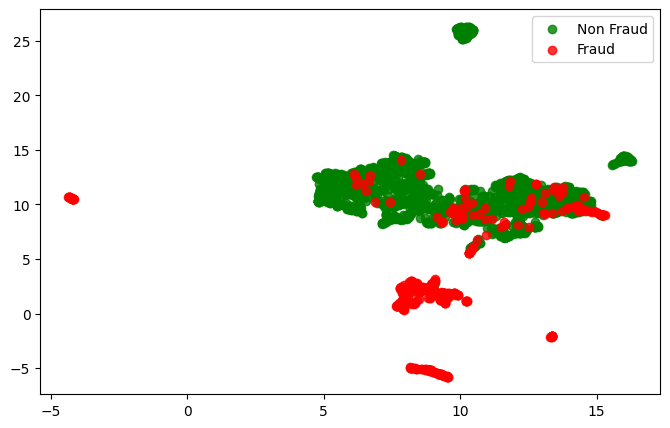

In [7]:
plot_map(df)

It is clear that Non-Fraud and Fraud are almost very close to each other thus are difficult for any normal classifier to classify this is where ***AUTOENCODERS*** comes to help.

**Preparing dataset**

In [28]:
X = dataset.drop("Class" , axis = 1).drop("Time", axis = 1).drop("Amount", axis = 1)
y = dataset["Class"].values

In [9]:
X = preprocessing.MinMaxScaler().fit_transform(X.values)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

## 2. Creating an AutoEncoder Model
An autoencoder consists of and encoder, latent space, and a decoder. The encoder layer compreses the input data to a latent space and the decoder layer decodes and uncompresses the data and reproduces the original data. We are goning to train this model for the entire data according to train_test_split and visualize the new  latent representation of our data.

In [32]:
class MyModel(tf.keras.Model):
    def __init__(self, latent_dim):
        super(MyModel, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = (X.shape[1], ), name = 'InputLayer'), 
                tf.keras.layers.Dense(100, kernel_initializer = 'uniform', activation = 'relu', name = 'Encoder_1'),
                tf.keras.layers.Dense(32, kernel_initializer = 'uniform', activation = 'tanh', name = 'Encoder_2'), 
                tf.keras.layers.Dense(latent_dim, kernel_initializer = 'uniform', activation = 'relu', name = 'Laten_Space')          
            ], 
            name = 'Encoder'
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = (latent_dim, )), 
                tf.keras.layers.Dense(100, kernel_initializer = 'uniform', activation = 'relu'),
                tf.keras.layers.Dense(32, kernel_initializer = 'uniform', activation = 'tanh'),
                tf.keras.layers.Dense(X.shape[1], kernel_initializer = 'uniform', activation = 'linear')
            ],
            name = 'Decoder'
        )
        
                
    def call(self, input_tensor):
        latent_space = self.encoder(input_tensor)
        reconstruction = self.decoder(latent_space)
        return reconstruction

In [33]:
encoder_model = MyModel(64)

In [34]:
encoder_model.compile(optimizer = 'adam', loss = 'mean_squared_error', experimental_run_tf_function = False)
encoder_model.fit(X_train[y_train == 0.0], X_train[y_train == 0.0], 
              validation_data = (X_test[y_test == 0.0], X_test[y_test == 0.0]), 
              batch_size = 256, epochs = 10, verbose = 1)

Epoch 1/10
778/778 [==============================] - 4s 4ms/step - loss: 0.6044 - val_loss: 0.4531
Epoch 2/10
778/778 [==============================] - 3s 4ms/step - loss: 0.3118 - val_loss: 0.3057
Epoch 3/10
778/778 [==============================] - 3s 4ms/step - loss: 0.2081 - val_loss: 0.2137
Epoch 4/10
778/778 [==============================] - 4s 5ms/step - loss: 0.1506 - val_loss: 0.1681
Epoch 5/10
778/778 [==============================] - 3s 4ms/step - loss: 0.1143 - val_loss: 0.1358
Epoch 6/10
778/778 [==============================] - 3s 4ms/step - loss: 0.0908 - val_loss: 0.1088
Epoch 7/10
778/778 [==============================] - 3s 4ms/step - loss: 0.0764 - val_loss: 0.0928
Epoch 8/10
778/778 [==============================] - 4s 5ms/step - loss: 0.0663 - val_loss: 0.0801
Epoch 9/10
778/778 [==============================] - 3s 4ms/step - loss: 0.0559 - val_loss: 0.0670
Epoch 10/10
778/778 [==============================] - 3s 4ms/step - loss: 0.0485 - val_loss: 0.0587

### 3. Let's visualize the dataset again but in its latent space representation after feeding it to the encoder model
Here we are going to pass 2000 non_fraud and 492 fraud datums. The reason is that we have a really big dataset and with over 100k non_fraud and only 492 fraud rows, the data here is too unbalanced thus it will be prudent of us to train with only 2000 samples of data.

In [36]:
y1 = dataset[dataset["Class"].values == 0].drop("Class" , axis = 1).drop("Time", axis = 1).drop("Amount", axis = 1)[:2000]
y2 = dataset[dataset["Class"].values == 1].drop("Class" , axis = 1).drop("Time", axis = 1).drop("Amount", axis = 1)
# feeding the fraud and non-fraud data in the encoding layer to get the latent space representation.
nofraud = encoder_model.encoder.predict(preprocessing.MinMaxScaler().fit_transform(y1))
fraud = encoder_model.encoder.predict(preprocessing.MinMaxScaler().fit_transform(y2))

16/16 [==============================] - 0s 998us/step


In [37]:
data = np.append(nofraud , fraud , axis = 0)

## 4. Visualization

(2492, 2)


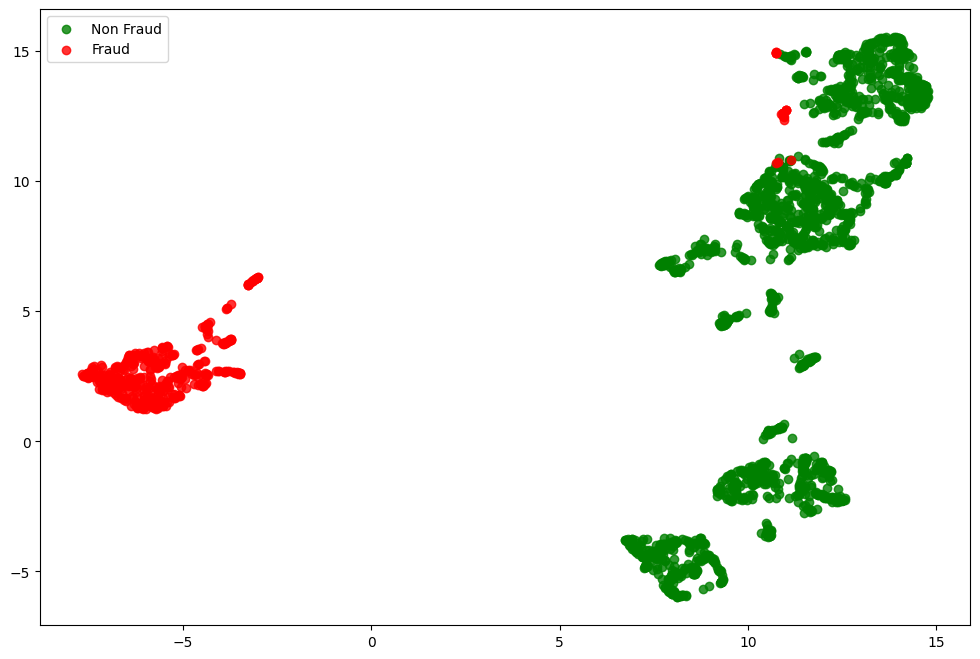

In [38]:
reducer = umap.UMAP()
scaled = StandardScaler().fit_transform(data)
embedding = reducer.fit_transform(scaled)
print(embedding.shape)
plt.figure(figsize=(12, 8))

y1 = np.arange(2000)
y2 = np.arange(2000,2492)
plt.scatter(embedding[y1, 0], embedding[y1, 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud' )
plt.scatter(embedding[y2, 0], embedding[y2, 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud' )
plt.legend(loc='best');
plt.savefig("Image.png");
plt.show()


## 5. Compare the results

****What we did?****

We first visualized the data in its ground truth form.

We than feeded that data to a trained autoencoder to get the representation in latent space.

We than Visualized the data or latent space output of the autoencoder.

We will now compare the Visualizations

Text(0.5, 1.0, 'After passing through the encoder')

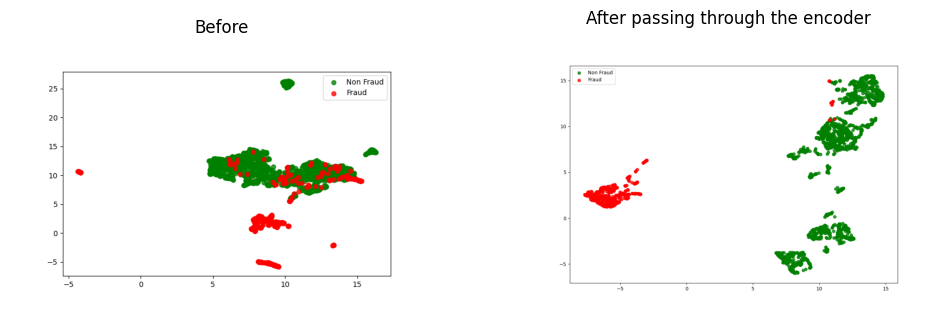

In [39]:
fig = plt.figure(figsize=(12, 10))

fig.add_subplot(1, 2, 1) 
  
# showing image 
image = plt.imread("/kaggle/working/image.png")
plt.imshow(image) 
plt.axis('off') 
plt.title("Before") 
fig.add_subplot(1, 2, 2) 
  
# showing image 
Image = plt.imread("/kaggle/working/Image.png")
plt.imshow(Image) 
plt.axis('off') 
plt.title("After passing through the encoder") 

We can see that the data is now more easy to distinct and classify.

### 6. Let's perform the evaluation on a classifier model like xgboost with the new data.

In [40]:
try:
    import xgboost
except:
    !pip install xgboost
    import xgboost
from sklearn.metrics import mean_squared_error, accuracy_score

In [41]:
y_nonfraud = np.zeros(2000)
y_fraud = np.ones(492)
y = np.append(y_nonfraud , y_fraud)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, shuffle = True)

In [42]:
classifier = xgboost.XGBClassifier(objective='binary:logistic', 
                              colsample_bytree=0.3, 
                              learning_rate=0.1, 
                              max_depth=5, 
                              alpha=10, 
                              n_estimators=300)

In [43]:
classifier.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [44]:
predictions = classifier.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


# Conclusion
* WIth the help of autoencoders, produced data with more distinguishable features as shown under section 5. Comparing the results.
* No doubt the accuracy is nearly perfect, xgboost itself can Classify the data with the accuracy of around 98 percent. With the help of autoencoders more easily classifiable data distribution was generated making xgboost reaching for 100% accuracy.